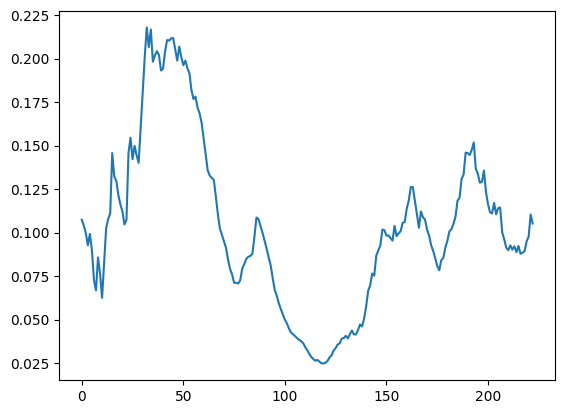

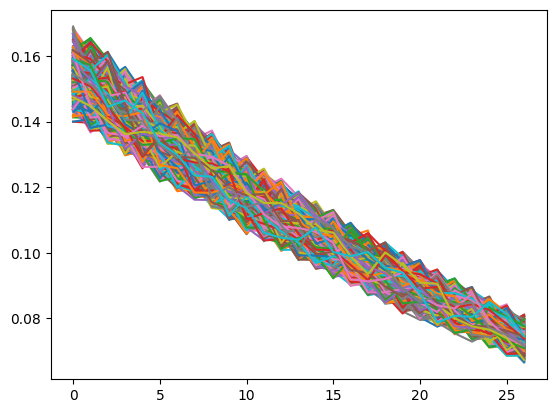

/var/folders/ls/yd1_54l95jq3d4wpt_5mrz980000gn/T/ipykernel_9780/717810353.py:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pf_beta[t])


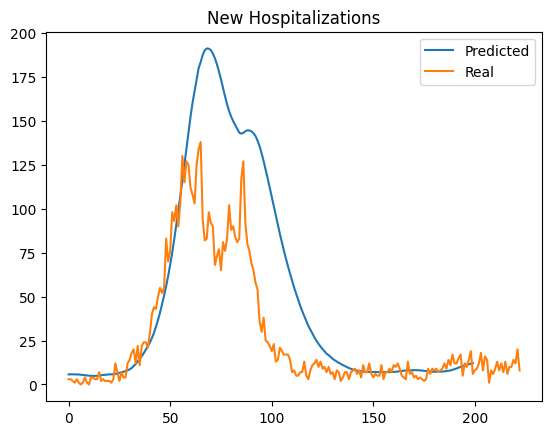

In [3]:
import numpy as np
from scipy.stats import nbinom
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import pandas as pd

predicted_beta = pd.read_csv('../datasets/out_logit-beta_trj_bootp.csv').to_numpy()
predicted_beta = np.delete(predicted_beta,0,1)

observations = pd.read_csv('../datasets/FLU_HOSPITALIZATIONS.csv').to_numpy()
observations = np.delete(observations,0,1)

estimated_state = pd.read_csv('../datasets/ESTIMATED_HOSP.csv').to_numpy()
estimated_state = np.delete(estimated_state,0,1)

pf_beta = pd.read_csv('../datasets/average_beta.csv').to_numpy()
pf_beta = np.delete(pf_beta,0,1)

plt.plot(pf_beta)
plt.show()

def RHS_H(t,state,param):
    #params has all the parameters – beta, gamma
    #state is a numpy array

        S,I,R,H,new_H = state #unpack the state variables
        N = S + I + R + H #compute the total population 

        new_H = (1/param['D'])*(param['gamma']) * I

        '''The state transitions of the ODE model is below'''
        dS = -param['beta'](int(t))*(S*I)/N + (1/param['L'])*R 
        dI = param['beta'](int(t))*S*I/N-(1/param['D'])*I
        dR = (1/param['hosp']) * H + ((1/param['D'])*(1-(param['gamma']))*I)-(1/param['L'])*R 
        dH = (1/param['D'])*(param['gamma']) * I - (1/param['hosp']) * H 

        return np.array([dS,dI,dR,dH,new_H])

def Jacobian(t,state,par):

    S,I,R,H,new_H = state
    N = S + I + R + H #compute the total population 
    return np.array([[-I*par.beta(int(t))/N,
                        -S*par.beta(int(t))/N,
                        1/par.L,0,0,],
                        [I*par.beta(int(t))/N,
                        S*par.beta(int(t))/N - 1/par.D,0,0,0,],
                        [0,(1 - par.gamma)/par.D,
                        -1/par.L,1/par.hosp,0,],
                        [0,par.gamma/par.D,0,
                        -1/par.hosp,0,],
                        [0,par.gamma/par.D,0,0,0,],])



for i in range(1000):
    plt.plot(predicted_beta[i,:])
plt.show()

def beta(t):
    return float(pf_beta[t])
    #return predicted_beta[500,t]

y0 = np.concatenate((estimated_state[0],observations[0]))


t_span = [0.0,200.0]
par={
"beta":beta,
"gamma":0.1,
"eta":0.1,
"std":10,
"hosp":15,
"L":90,
"D":10}

# betas = []
# t_span_test = np.linspace(0,26,100)
# for t in range(len(t_span_test)): 
#     betas.append(par['beta'](int(t_span_test[t])))
# plt.plot(t_span_test,betas)
# plt.show()

sol =  solve_ivp(fun=lambda t,z: RHS_H(t,z,par), 
                    jac=lambda t,z:Jacobian(t,z,par), 
                    t_span=t_span,
                    t_eval= np.linspace(0.0,200.0,num=201),
                    y0=y0,
                    method='LSODA')



plt.title('New Hospitalizations')
plt.plot(np.diff(sol.y[4,:]),label = "Predicted")
plt.plot(observations,label = "Real")
plt.legend()
            


